# Guandu geosmin crisis forecast

This notebook aims to analyse geosmin data, in particular how the concentration decays over time. For this, we'll be using the geosmin data extracted by the `guandu_extract_and_clean` notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import os

In [3]:
csv_dir = os.path.join('output', 'guandu')

In [4]:
df1 = pd.read_csv(os.path.join(csv_dir, 'geosmin_2020-01-26_2020-03-18.csv'), index_col='date')

In [5]:
df1.head()

,capture_geosmin,etas_geosmin,is_capture_geosmin_ub,is_etas_geosmin_ub
date,,,,
2020-01-26,1.50,0.820,False,False
2020-01-27,1.20,0.431,False,False
2020-01-28,1.96,0.758,False,False
2020-01-29,1.59,0.802,False,False
2020-01-30,1.56,0.838,False,False


In [6]:
df2 = pd.read_csv(os.path.join(csv_dir, 'geosmin_2020-10-23_today.csv'), index_col='date')

In [7]:
df2.head()

,capture_geosmin,veta_geosmin,neta_geosmin,is_capture_geosmin_ub,is_veta_geosmin_ub,is_neta_geosmin_ub
date,,,,,,
2020-10-23,0.01,0.01,0.01,True,True,True
2020-10-24,0.01,0.01,0.01,True,True,True
2020-10-25,0.01,0.01,0.01,True,True,True
2020-10-26,0.01,0.01,0.01,True,True,True
2020-10-27,0.01,0.01,0.01,True,True,True


Since we're only going to use data from the capture point, we're discarding all the rest. This means we can join both data frames into one.

In [8]:
columns = ['capture_geosmin', 'is_capture_geosmin_ub']
df3 = pd.concat([df1[columns], df2[columns]])
df3.index = pd.to_datetime(df3.index)

In [9]:
df3.shape

(278, 2)

In [10]:
df3.head()

,capture_geosmin,is_capture_geosmin_ub
date,,
2020-01-26,1.50,False
2020-01-27,1.20,False
2020-01-28,1.96,False
2020-01-29,1.59,False
2020-01-30,1.56,False


<Figure size 432x288 with 0 Axes>

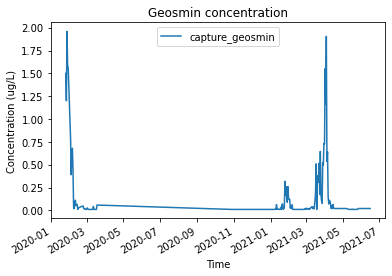

In [11]:
plt.figure()
df3.plot(title='Geosmin concentration', xlabel='Time', ylabel='Concentration (ug/L)')
plt.show()

Some of the samples are below a certain threshold and have so little geosmin that CEDAE only shares the upperbound. We decide to chop the samples into sections of non-upperbound values. We do this by adding a new column `section` which receives an integer. Every sample of a section have the same section number. Samples that are only upper bounds belong to section `0`.

In [12]:
nsections = 0
insection = False
sections = np.zeros(len(df3), dtype=np.int32)
index = 0
for date, row in df3.iterrows():
    if row.is_capture_geosmin_ub:
        insection = False
    else:
        if not insection:
            nsections += 1
            insection = True
        sections[index] = nsections
    index += 1
df3['section'] = sections

Now, let's plot each section with a different color. We also only plot the part from the highest concentration to the end.

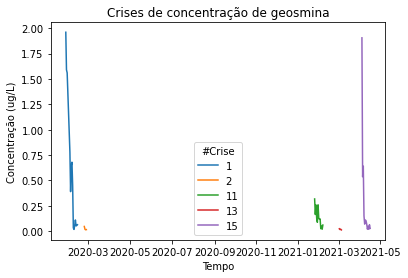

In [21]:
sections = {}
plt.figure()
plt.title('Crises de concentração de geosmina')
plt.xlabel('Tempo')
plt.ylabel('Concentração (ug/L)')
for section in range(1,nsections+1):
    df = df3[df3.section == section][['capture_geosmin']]
    peakday = df.index[np.argmax(df.capture_geosmin)]
    df = df[df.index >= peakday]
    if len(df) > 1 and df.capture_geosmin[peakday] > 0.02:
        sections[section] = df
        plt.plot(df.capture_geosmin, label=section)
plt.legend(title='#Crise', loc='best')
plt.show()

In [14]:
peaks = {}
durations = {}
for section, df in sections.items():
    peaks[section] = df.capture_geosmin[df.index[0]]
    durations[section] = np.ptp(df.index) / np.timedelta64(1, 'D')
df4 = pd.DataFrame({'peak': peaks, 'duration':durations})

In [15]:
df4

,peak,duration
1,1.960,17.0
2,0.047,3.0
11,0.318,12.0
13,0.024,3.0
15,1.905,12.0


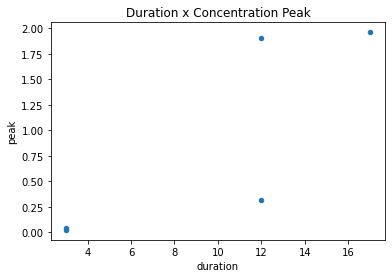

In [16]:
ax = df4.plot.scatter('duration', 'peak', title='Duration x Concentration Peak')

In [17]:
df4.corr()

,peak,duration
peak,1.000000,0.821478
duration,0.821478,1.000000


In [18]:
def func(x, a, b, c):
    return a * np.exp(b * x) + c

def func_inv(x, a, b, c):
    return np.log((x-c)/a)/b

df5 = df4.sort_values(by=['duration'])
x = df5.duration
y = df5.peak
popt, pcov = curve_fit(func, x, y)

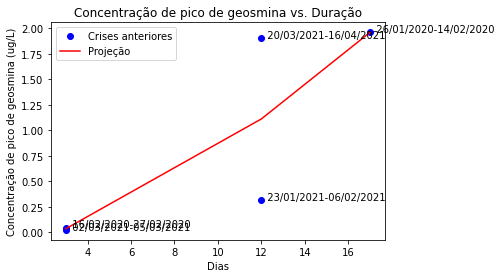

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Concentração de pico de geosmina vs. Duração')
plt.plot(x, y, 'bo', label="Crises anteriores")
datefmt = '%d/%m/%Y'
for section, row in df5.iterrows():
    px, py = row.duration, row.peak
    dates = df3[df3.section == section].index
    label = '  ' + np.min(dates).strftime(datefmt) + '-' + np.max(dates).strftime(datefmt)
    ax.annotate(label, xy=(px, py), textcoords='data')
plt.xlabel('Dias')
plt.ylabel('Concentração de pico de geosmina (ug/L)')
a, b, c = popt
yf = func(x, *popt)
xf = func_inv(y, *popt)
plt.plot(x, yf, 'r-', label="Projeção")
plt.legend()
plt.show()

In [19]:
y_rmsd = np.sqrt(np.mean(np.square(yf-y)))
x_rmsd = np.sqrt(np.mean(np.square(xf-x)))
print('Peak concentration RMSD = {:.2f} ug/L'.format(y_rmsd))
print('Days RMSD = {:.2f}'.format(x_rmsd))

Peak concentration RMSD = 0.50 ug/L
Days RMSD = 3.49


We can try to make predictions now of how much time the crisis will be solved, if we know the peak concentration.

In [20]:
def predict_peak(x):
    return func(x, *popt)

def predict_days(y):
    return func_inv(y, *popt)

In [24]:
peak = float(input('Enter peak concentration in ug/L: '))
days = predict_days(peak)
print('It should take at least {:.2f}±{:.2f} days'.format(days, x_rmsd))

Enter peak concentration in ug/L: 10
It should take at least 39.41±3.49 days
